## RAG EVALUATION METRICS COMPARISON

### REQUIREMENTS

In [1]:
!pip install langchain langchain-community langchain-groq langchain-huggingface \
    sentence-transformers faiss-cpu pypdf bert-score scikit-learn python-dotenv plotly

!pip install deepeval trulens giskard ragas datasets
!pip install trulens-core trulens-providers-openai
!pip install trulens-dashboard
!pip install trulens-apps-langgraph
!pip install rapidfuzz


  Using cached trulens_apps_langgraph-2.1.3-py3-none-any.whl.metadata (1.3 kB)
  Using cached langgraph-0.5.4-py3-none-any.whl.metadata (6.8 kB)
  Using cached trulens_apps_langchain-2.1.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached langgraph_checkpoint-2.1.1-py3-none-any.whl.metadata (4.2 kB)
  Using cached langgraph_prebuilt-0.5.2-py3-none-any.whl.metadata (4.5 kB)
  Using cached langgraph_sdk-0.1.74-py3-none-any.whl.metadata (1.5 kB)
  Using cached ormsgpack-1.10.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (43 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 43.6 MB/s eta 0:00:00


### IMPORTS

In [2]:
import os, re
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from bert_score import score as bert_score
from sklearn.metrics.pairwise import cosine_similarity
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import TokenTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
from openai import OpenAIError
from groq import Groq


In [3]:
DEEPEVAL = TRULENS = GISKARD = RAGAS = False

try:
    import deepeval
    from deepeval.metrics import AnswerRelevancyMetric, FaithfulnessMetric, ContextualRelevancyMetric, ContextualPrecisionMetric, ContextualRecallMetric
    from deepeval.test_case import LLMTestCase
    DEEPEVAL = True
except: pass

try:
    import trulens
    from trulens.feedback import GroundTruthAgreement
    TRULENS = True
except: pass

try:
    import giskard
    GISKARD = True
except: pass

try:
    from ragas.llms import LangchainLLMWrapper
    from ragas.embeddings import LangchainEmbeddingsWrapper
    from ragas.evaluation import evaluate
    from ragas.metrics import ContextPrecision, ContextRecall, Faithfulness
    from datasets import Dataset
    RAGAS = True
except: pass

### FILE LOADING-CHUNKING-EMBEDDING

##### SETUP

In [4]:
from google.colab import userdata

OPENAI_API_KEY = userdata.get("OPENAI_API_KEY")
GROQ_KEY = userdata.get("GROQ_KEY")
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
os.environ["GROQ_KEY"] = GROQ_KEY

In [15]:
PDF_PATH      = "sample.pdf"
CSV_PATH      = "qa.csv"
MODEL_NAME    = "llama3-8b-8192"
TOP_K         = 3

client = Groq(api_key=GROQ_KEY)

loader   = PyPDFLoader(PDF_PATH)
pages    = loader.load()
splitter = TokenTextSplitter(chunk_size=800, chunk_overlap=150)
chunks   = splitter.split_documents(pages)

hf_embeddings  = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vectorstore    = FAISS.from_documents(chunks, hf_embeddings)
retriever      = vectorstore.as_retriever(search_kwargs={"k": TOP_K})

qa_df = pd.read_csv(CSV_PATH).fillna("")
assert all(col in qa_df for col in ["Question", "Reference Answer"])

def retrieve_contexts(question: str) -> list[str]:
    docs = retriever.invoke(question)
    return [doc.page_content for doc in docs]

qa_df["contexts"] = qa_df["Question"].apply(retrieve_contexts)

def generate_answer(question, contexts):
    context_block = "\n\n".join(f"[{i+1}] {txt}" for i, txt in enumerate(contexts))
    prompt = (
        "You are an expert factual assistant. Answer using ONLY the provided context; "
        "if insufficient, reply 'Insufficient information.'\n\n"
        f"{context_block}\n\nQuestion: {question}\nAnswer:"
    )
    resp = client.chat.completions.create(
        model=MODEL_NAME,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.0
    )
    return resp.choices[0].message.content.strip()

qa_df["answer"] = qa_df.apply(lambda row: generate_answer(row["Question"], row["contexts"]), axis=1)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packa

### MODERN FRAMEWORKS

#### DEEPEVAL

In [6]:
from deepeval.metrics import (
    AnswerRelevancyMetric, FaithfulnessMetric, ContextualRelevancyMetric,
    ContextualPrecisionMetric, ContextualRecallMetric, ToxicityMetric,
    HallucinationMetric
)
from deepeval.test_case import LLMTestCase

def evaluate_with_deepeval(q, a, ctx_list, ref):
    case = LLMTestCase(
        input=q,
        actual_output=a,
        expected_output=ref,
        retrieval_context=ctx_list,
        context=ctx_list
    )
    metrics = [
        AnswerRelevancyMetric(),
        FaithfulnessMetric(),
        ContextualRelevancyMetric(),
        ContextualPrecisionMetric(),
        ContextualRecallMetric(),
        ToxicityMetric(),
        HallucinationMetric()
    ]
    results = {}
    for m in metrics:
        m.measure(case)
        results[m.__class__.__name__] = getattr(m, "score", None)
    return results



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Output()

Output()

Output()

Output()

Output()

Output()

Output()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Output()

Output()

Output()

Output()

Output()

Output()

Output()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Output()

Output()

Output()

Output()

Output()

Output()

Output()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Output()

Output()

Output()

Output()

Output()

Output()

Output()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Output()

Output()

Output()

Output()

Output()

Output()

Output()

,AnswerRelevancyMetric,FaithfulnessMetric,ContextualRelevancyMetric,ContextualPrecisionMetric,ContextualRecallMetric,ToxicityMetric,HallucinationMetric
Q#,,,,,,,
1,1.000,1.000,0.778,1.000,1.000,0.000,0.000
2,1.000,1.000,0.083,0.333,0.500,0.000,0.667
3,0.800,1.000,0.500,0.500,0.000,0.000,0.000
4,1.000,1.000,0.348,0.333,1.000,0.000,0.000
5,1.000,1.000,0.185,1.000,1.000,0.000,0.000


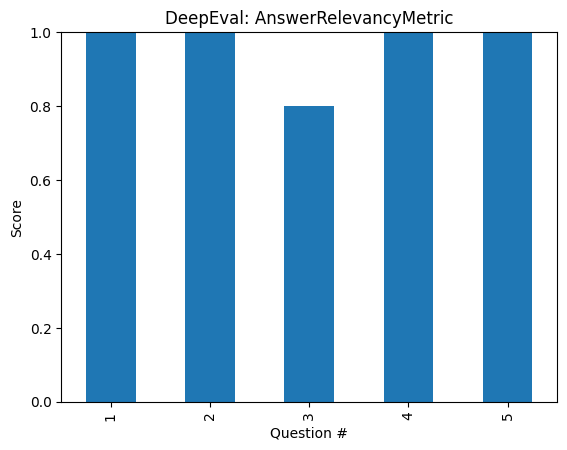

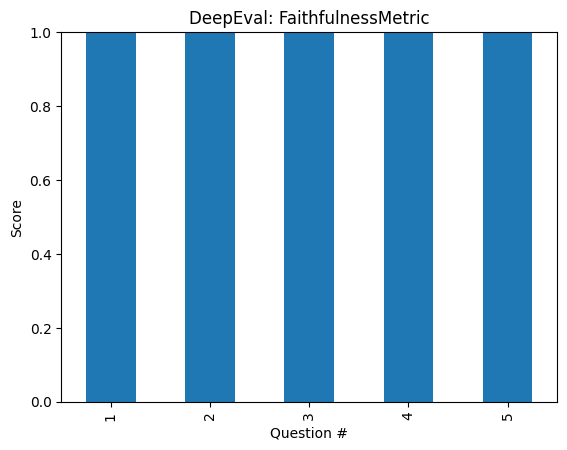

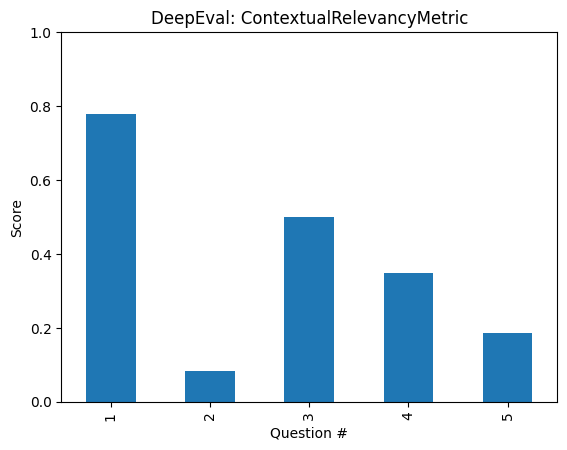

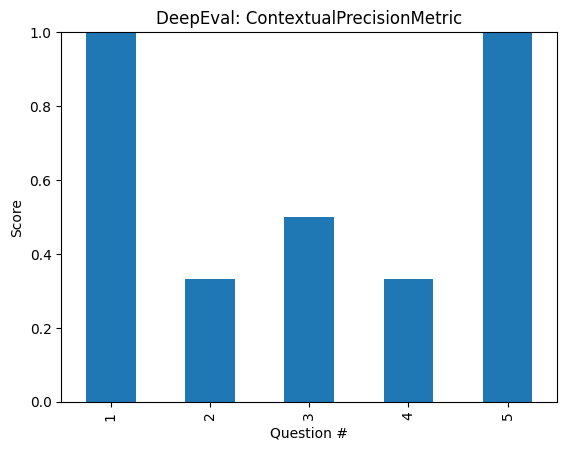

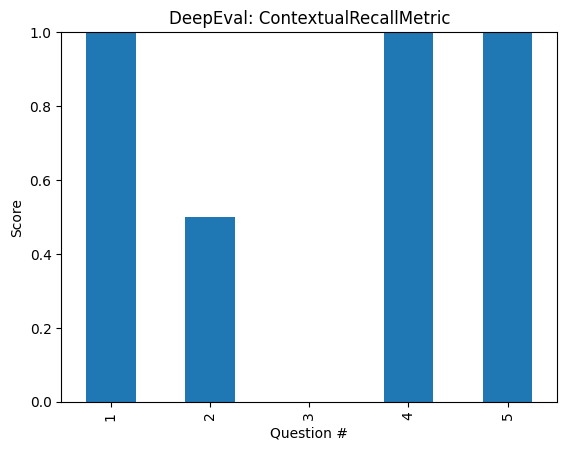

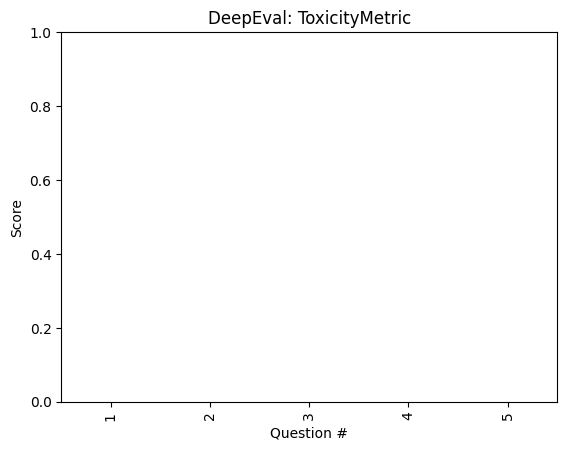

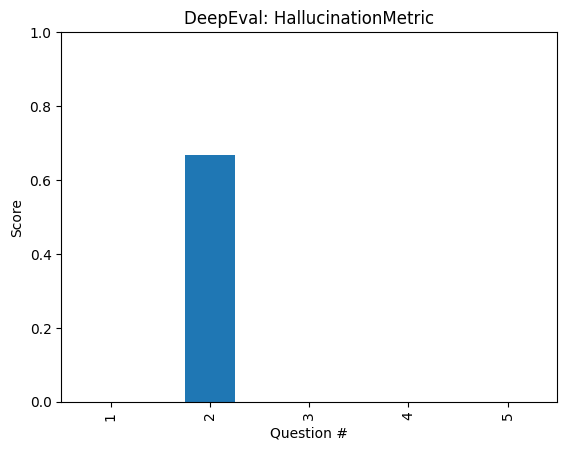

In [7]:
import time

deepeval_rows = []

for idx, row in qa_df.iterrows():
    q = row["Question"]
    ref = str(row["Reference Answer"]).strip()
    gt_chunks = str(row["Relevant Chunk IDs"])
    relevant_ids = [int(i.strip()) for i in re.split(r"[,\s]+", gt_chunks) if i.strip().isdigit()]

    docs = retriever.invoke(q)

    context_list = [d.page_content[:1500] for d in docs[:5]]
    context = "\n\n".join(context_list)

    model = ChatGroq(groq_api_key=os.environ["GROQ_KEY"], model_name="llama3-8b-8192")
    prompt = f"Use only this context to answer:\n\n{context}\n\nQ: {q}\nA:"
    answer = model.invoke(prompt).content.strip()

    try:
        dr = evaluate_with_deepeval(q, answer, context_list, ref)
    except Exception as e:
        print(f"Evaluation failed for Q#{idx+1}: {e}")
        dr = {"Q#": idx+1, "Error": str(e)}

    dr["Q#"] = idx + 1
    deepeval_rows.append(dr)

    time.sleep(1.5)

deepeval_df = pd.DataFrame(deepeval_rows).set_index("Q#")

display(deepeval_df.style.format("{:.3f}"))

import matplotlib.pyplot as plt

for col in deepeval_df.columns:
    deepeval_df.plot.bar(y=col, legend=False, title=f"DeepEval: {col}")
    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.xlabel("Question #")
    plt.show()



#### RAGAS

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]


RAGAS Evaluation Results :
 Q#  ContextualPrecisionMetric  ContextualRecallMetric  FaithfulnessMetric  AnswerRelevancyMetric  AnswerCorrectnessMetric
  1                      1.000                   1.000               1.000                  1.000                    0.974
  2                      0.583                   0.000               1.000                  0.858                    0.383
  3                      1.000                   0.000               1.000                  1.000                    0.206
  4                      1.000                   0.000               0.000                  0.000                    0.186
  5                      1.000                   1.000               1.000                  0.978                    0.869


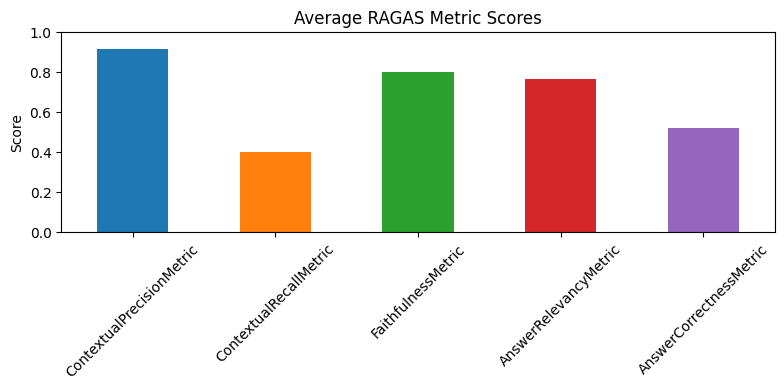

In [8]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.evaluation import evaluate
from ragas.metrics import ContextPrecision, ContextRecall, Faithfulness
from datasets import Dataset

from ragas.metrics import (
    context_precision,
    context_recall,
    faithfulness,
    answer_relevancy,
    answer_correctness
)

ragas_dataset = Dataset.from_dict({
    "question": qa_df["Question"].tolist(),
    "contexts": qa_df["contexts"].tolist(),
    "answer": qa_df["answer"].tolist(),
    "ground_truth": qa_df["Reference Answer"].tolist()
})

metrics = [
    context_precision,
    context_recall,
    faithfulness,
    answer_relevancy,
    answer_correctness
]

results = evaluate(ragas_dataset, metrics=metrics)
results_df = results.to_pandas()

metric_df = results_df.select_dtypes(include="float")

rename_map = {
    "context_precision": "ContextualPrecisionMetric",
    "context_recall": "ContextualRecallMetric",
    "faithfulness": "FaithfulnessMetric",
    "answer_relevancy": "AnswerRelevancyMetric",
    "answer_correctness": "AnswerCorrectnessMetric"
}
metric_df = metric_df.rename(columns=rename_map)

metric_df.insert(0, "Q#", range(1, len(metric_df) + 1))

pd.set_option("display.float_format", lambda x: f"{x:.3f}")

print("\nRAGAS Evaluation Results :")
print(metric_df.to_string(index=False))

avg_scores = metric_df.iloc[:, 1:].mean()

plt.figure(figsize=(8, 4))
avg_scores.plot.bar(color=sns.color_palette("tab10"))
plt.ylim(0, 1)
plt.title("Average RAGAS Metric Scores")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()





#### TRULENS

In [9]:
from tqdm import tqdm
import openai
import os
from trulens.providers.openai import OpenAI as TruOpenAI
from trulens.core.feedback import Feedback
import pandas as pd


openai.api_key = os.getenv("OPENAI_API_KEY")

def retrieve_contexts(question):
    docs = retriever.invoke(question)
    return [doc.page_content for doc in docs]

qa_df["contexts"] = qa_df["Question"].apply(retrieve_contexts)


def generate_answer(question, contexts):
    context_block = "\n\n".join(f"[{i+1}] {ctx}" for i, ctx in enumerate(contexts))
    prompt = (
        "You are an expert factual assistant. Answer using ONLY the provided context; "
        "if insufficient information, reply 'Insufficient information.'\n\n"
        f"{context_block}\n\nQuestion: {question}\nAnswer:"
    )
    response = openai.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.0,
    )
    return response.choices[0].message.content.strip()

print("Generating answers (this may take a few minutes)...")
qa_df["answer"] = qa_df.apply(lambda row: generate_answer(row["Question"], row["contexts"]), axis=1)


tru_provider = TruOpenAI()

qa_df["context_block"] = qa_df["contexts"].apply(lambda ctx_list: "\n\n".join(ctx_list))

f_context_relevance = Feedback(tru_provider.context_relevance)
f_groundedness = Feedback(tru_provider.groundedness_measure_with_cot_reasons)
f_answer_relevance = Feedback(tru_provider.relevance)
f_conciseness = Feedback(tru_provider.conciseness)
f_helpfulness = Feedback(tru_provider.helpfulness)

print("Evaluating answers with TruLens metrics...")

results = []
for idx, row in tqdm(qa_df.iterrows(), total=len(qa_df)):
    question = row["Question"]
    context_block = row["context_block"]
    answer = row["answer"]

    context_score = f_context_relevance(question=question, context=context_block)

    groundedness_result = f_groundedness(source=context_block, statement=answer)
    if isinstance(groundedness_result, tuple):
        groundedness_score, groundedness_meta = groundedness_result
    else:
        groundedness_score = groundedness_result
        groundedness_meta = {"reasons": "N/A"}

    answer_relevance_score = f_answer_relevance(prompt=question, response=answer)
    conciseness_score = f_conciseness(text=answer)
    helpfulness_score = f_helpfulness(text=answer)

    results.append({
        "Q#": idx + 1,
        "Question": question,
        "Answer": answer,
        "ContextRelevance": context_score,
        "Groundedness": groundedness_score,
        "GroundednessReasons": groundedness_meta.get("reasons", "N/A"),
        "AnswerRelevance": answer_relevance_score,
        "Conciseness": conciseness_score,
        "Helpfulness": helpfulness_score
    })

results_df = pd.DataFrame(results)

pd.set_option('display.max_colwidth', 100)
print("\n=== TruLens Evaluation Results (Summary) ===\n")
print(results_df[[
    "Q#", "ContextRelevance", "Groundedness", "AnswerRelevance",
    "Conciseness", "Helpfulness"
]])


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packa

Generating answers (this may take a few minutes)...
Evaluating answers with TruLens metrics...


100%|██████████| 5/5 [00:31<00:00,  6.23s/it]


=== TruLens Evaluation Results (Summary) ===

   Q#  ContextRelevance  Groundedness  AnswerRelevance  Conciseness  \
0   1             1.000         1.000            0.000        0.333   
1   2             1.000         1.000            0.000        1.000   
2   3             1.000         1.000            0.000        1.000   
3   4             0.667         1.000            0.000        1.000   
4   5             1.000         1.000            0.000        1.000   

   Helpfulness  
0        0.000  
1        0.000  
2        0.000  
3        0.000  
4        0.000  


#### ARES

#### ARIZE PHOENIX

#### OpenAI EVALS

### TRADITIONAL METRICS

In [11]:
def recall_at_k(retrieved, relevant, k):
    return len(set(retrieved[:k]) & set(relevant)) / max(len(set(relevant)), 1)
def precision_at_k(retrieved, relevant, k):
    return len(set(retrieved[:k]) & set(relevant)) / max(k, 1)
def mrr(retrieved, relevant):
    for i, r in enumerate(retrieved, 1):
        if r in relevant: return 1/i
    return 0.0
def answer_relevance(q, a):
    qv, av = hf_embeddings.embed_query(q), hf_embeddings.embed_query(a)
    return float(cosine_similarity([qv],[av])[0][0])
def bertscore(a, ref):
    P, R, F1 = bert_score([a], [ref], lang="en", model_type="bert-base-uncased")
    return float(P[0]), float(R[0]), float(F1[0])


In [12]:
llm = ChatGroq(groq_api_key=GROQ_KEY, model_name="llama3-8b-8192")
k = 3

In [13]:
traditional_rows = []

for idx, row in qa_df.iterrows():
    q = row["Question"]
    gt_chunks = str(row["Relevant Chunk IDs"])
    ref = str(row["Reference Answer"]).strip()
    relevant_ids = [int(i.strip()) for i in re.split(r"[,\s]+", gt_chunks) if i.strip().isdigit()]
    docs = retriever.invoke(q)
    retrieved_ids, retrieved_docs = [], []
    for doc in docs:
        match = [i for i, c in enumerate(chunks) if c.page_content == doc.page_content]
        if match:
            retrieved_ids.append(match[0])
            retrieved_docs.append(doc)
    prompt = f"Use only this context to answer:\n\n{chr(10).join([d.page_content for d in retrieved_docs])}\n\nQ: {q}\nA:"
    model_resp = llm.invoke(prompt)
    answer = model_resp.content if hasattr(model_resp, "content") else str(model_resp)
    answer = answer.strip()
    r_at_k = recall_at_k(retrieved_ids, relevant_ids, k)
    p_at_k = precision_at_k(retrieved_ids, relevant_ids, k)
    mrr_val = mrr(retrieved_ids, relevant_ids)
    cos_sim = answer_relevance(q, answer)
    bertP, bertR, bertF1 = bertscore(answer, ref) if ref else (None, None, None)
    traditional_rows.append({
        "Q#": idx+1, "Recall@k": r_at_k, "Precision@k": p_at_k, "MRR": mrr_val,
        "Cosine Similarity (Q↔A)": cos_sim, "BERTScore (P)": bertP, "BERTScore (R)": bertR, "BERTScore (F1)": bertF1
    })
traditional_df = pd.DataFrame(traditional_rows)
display(traditional_df.style.format("{:.3f}"))


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packa

,Q#,Recall@k,Precision@k,MRR,Cosine Similarity (Q↔A),BERTScore (P),BERTScore (R),BERTScore (F1)
0,1.000,0.667,0.667,1.000,0.909,0.615,0.610,0.612
1,2.000,0.000,0.000,0.000,0.912,0.534,0.529,0.532
2,3.000,0.250,0.333,0.500,0.869,0.444,0.538,0.486
3,4.000,0.500,0.333,0.333,0.888,0.618,0.525,0.567
4,5.000,0.333,0.333,1.000,0.907,0.575,0.576,0.576


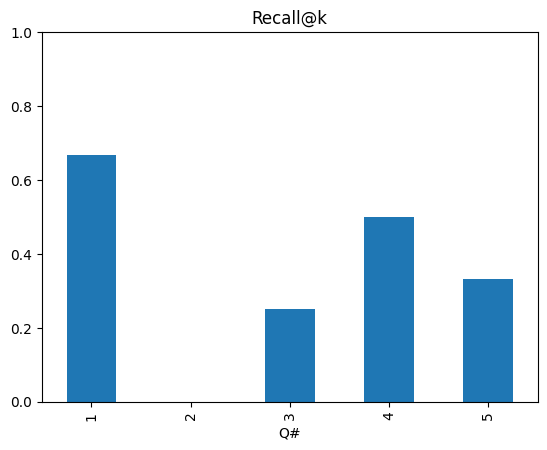

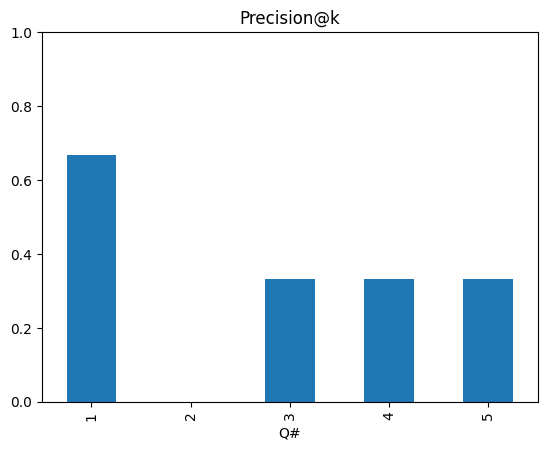

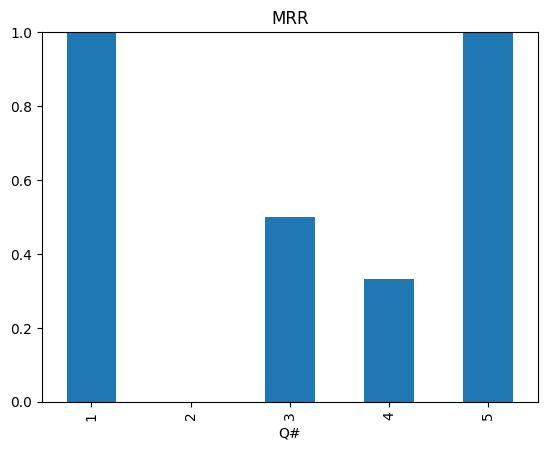

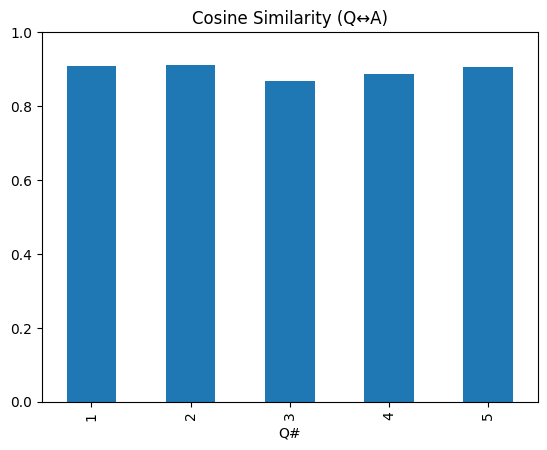

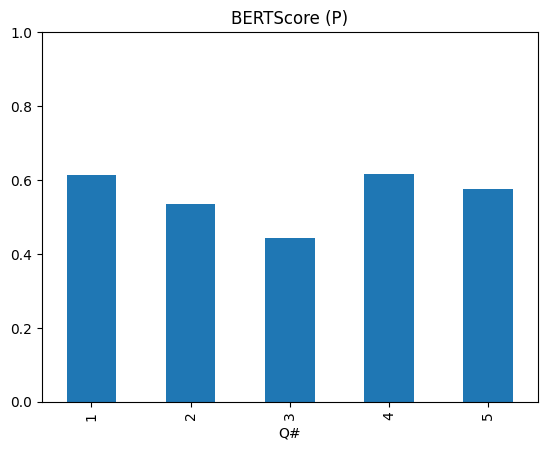

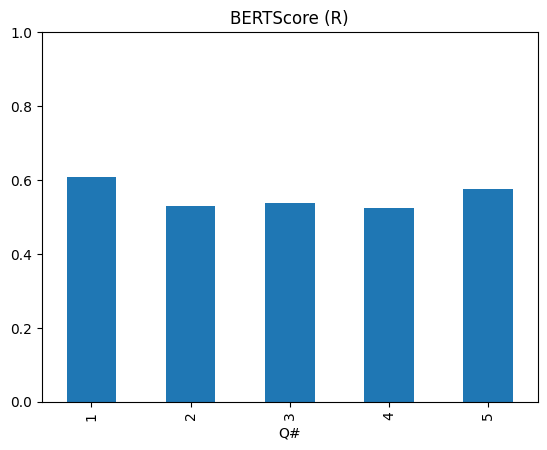

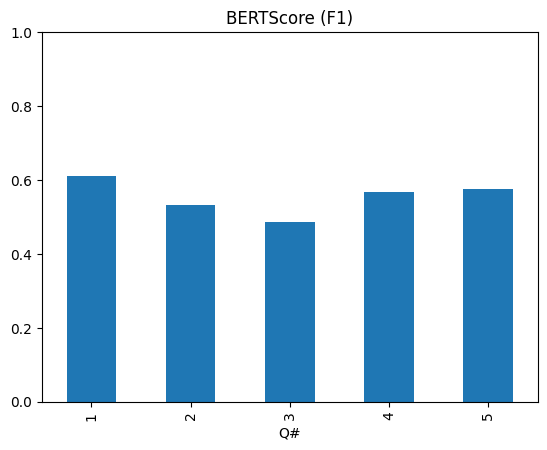

In [14]:
import matplotlib.pyplot as plt
for col in traditional_df.columns[1:]:
    traditional_df.plot.bar(x="Q#", y=col, legend=False, title=col)
    plt.ylim(0, 1)
    plt.show()
